### Среднемесячный уровень заработной платы в России

* Визуальный анализ ряда
* Стабилизация дисперсии (при необходимости)
* Выбор порядка дифференцирования
* Выбор начальных приближений для p,q,P,Q
* Обучение и сравнение моделей-кандидатов
* Анализ остатков модели и ее модификация (при необходимости): _если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p,q,P,Q;_
* Прогнозирование с помощью финальной модели


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

In [2]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
    
def decomposition(series):
    
    plt.figure(figsize=(15, 2.5))
    plt.title('Observed')
    plt.xlabel('Month')
    plt.ylabel('Salary')
    plt.plot(series.index, series.values)
    
    decompose = sm.tsa.seasonal_decompose(series)
    plt.subplots(nrows=3,ncols=1,figsize=(15,10))
    plt.subplots_adjust(hspace = 0.4)

    plt.subplot(311)
    plt.title('Trend')
    decompose.trend.plot()

    plt.subplot(312)
    plt.title('Seasonal')
    decompose.seasonal.plot()

    plt.subplot(313)
    plt.title('Resid')
    decompose.resid.plot()

In [3]:
salary = pd.read_csv('WAG_C_M.csv', sep = ';', index_col = ['month'], parse_dates = ['month'], dayfirst = True)

## Визуальный анализ ряда

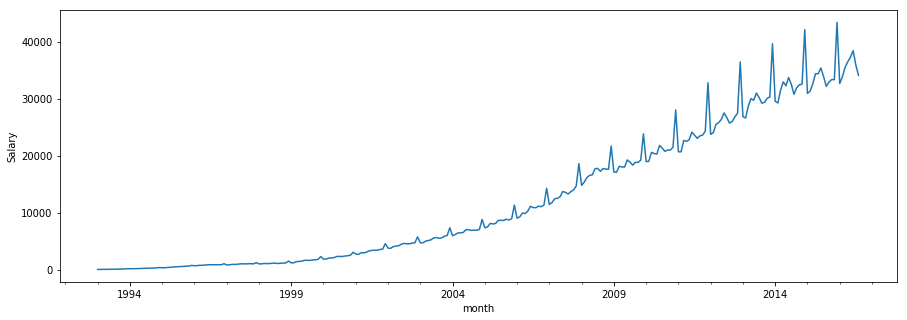

In [4]:
#визуализация ряда без каких-либо изменений.

plt.figure(figsize=(15,5))
salary.WAG_C_M.plot()
plt.ylabel('Salary')
plt.show()

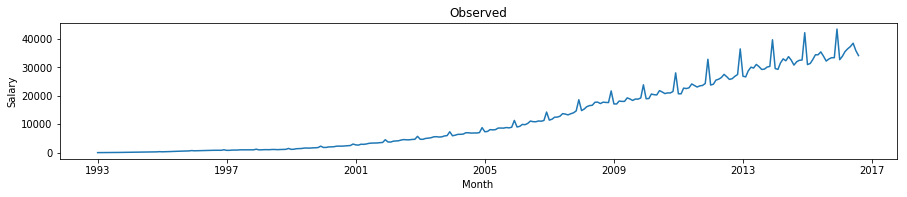

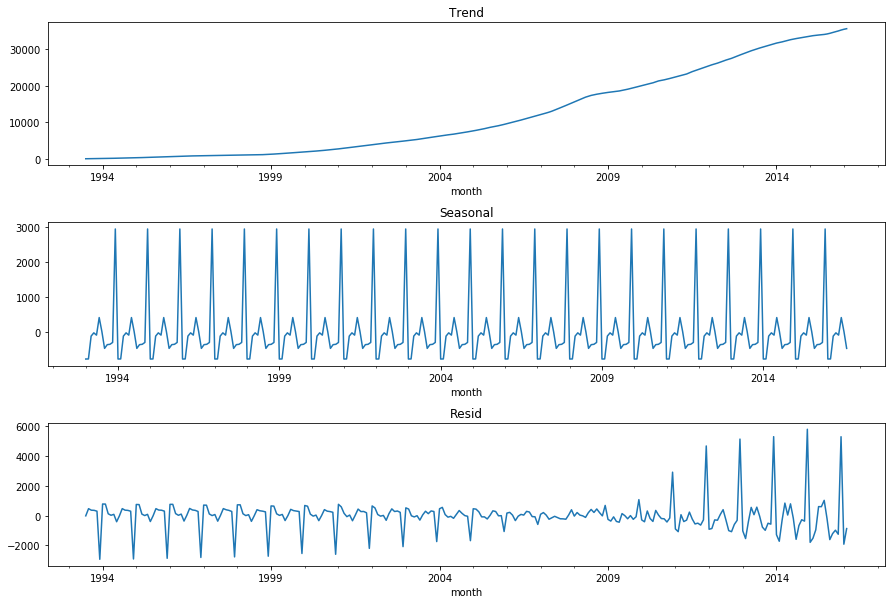

In [5]:
#построение декомпозиции ряда
decomposition(salary.WAG_C_M)

In [6]:
#расчет критерия Дики-Фуллера для проверки гипотезы на нестационарность ряда.

print('Критерий Дики-Фуллера:', sm.tsa.stattools.adfuller(salary['WAG_C_M'])[1])

Критерий Дики-Фуллера: 0.991849595485


Даже на графике исходного ряда заметно, что он не стационарный. У дисперсии заметно увеличивается размах, что свидетельствует о ее нестабильности. Ярко выражен повышающийся тренд, что подтверждается декомпозицей ряда. 

Также данные слова подтверждает и критерий Дики-Фуллера. Он не отвергает гипотезу о нестационарности ряда. 

Поэтому нужно провести стабилизацию дисперсии и дальнейшие преобразования ряда, такие как сезонное диффернцирование не обойти. 

## Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899

TRANSFORMED WITH BOXCOX:


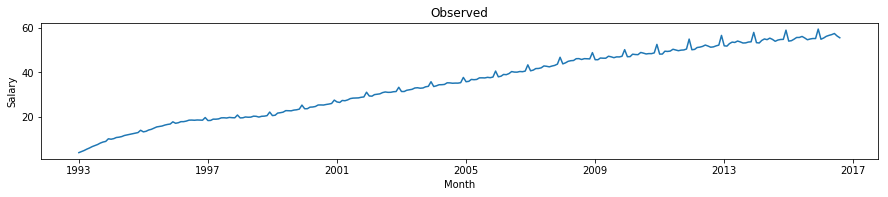

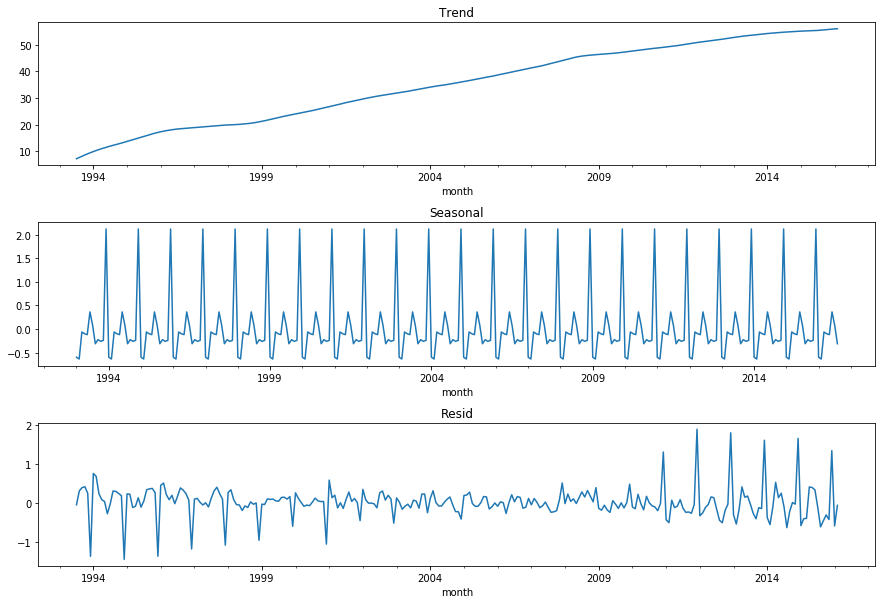

In [7]:
salary['WAG_BoxCox'], lmbda = stats.boxcox(salary['WAG_C_M'])

decomposition(salary.WAG_BoxCox)

print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary['WAG_BoxCox'])[1])

print("\nTRANSFORMED WITH BOXCOX:")

На преобразованном графике заметно, что дисперсия стала намного менее выраженной. Но критерий Дики-Фуллера все еще не отклоняет гипотезу о нестационарности. 

Нужно избавиться от тренда. Сделаем сезонное диффернцирование.

### Стационарность. Выбор порядка диффернцирования.

Проведем для начала сезонное диффернцирование.

Критерий Дики-Фуллера: p=0.014697

TRANSFORMED WITH BOXCOX AND SEASONAL DIFF:


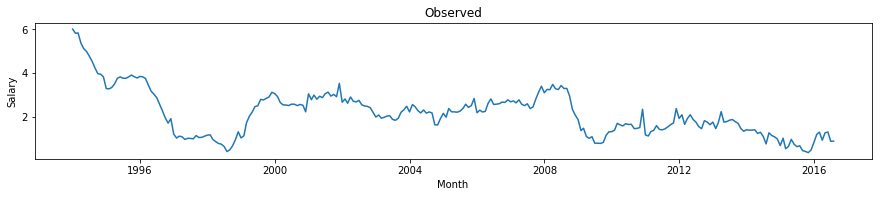

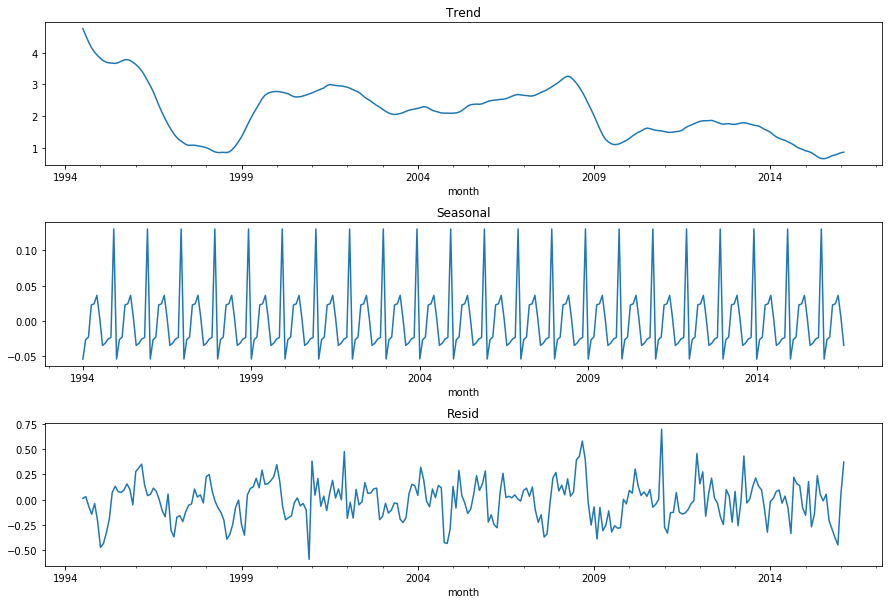

In [8]:
salary['BoxCox_SeasDiff'] = salary['WAG_BoxCox'] - salary['WAG_BoxCox'].shift(12)

decomposition(salary.BoxCox_SeasDiff.dropna())

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary['BoxCox_SeasDiff'].dropna())[1])

print("\nTRANSFORMED WITH BOXCOX AND SEASONAL DIFF:")

Критерий Дики-Фуллера уже отвергает нестационарность ряда. Но все-таки некоторая структура тренда все еще заметна. Для лучшего результата попробуем провести еще одно диффернцирование ряда.

Критерий Дики-Фуллера: p= 5.20360371582e-08

TRANSFORMED WITH BOXCOX SEASONAL AND USUAL DIFF:


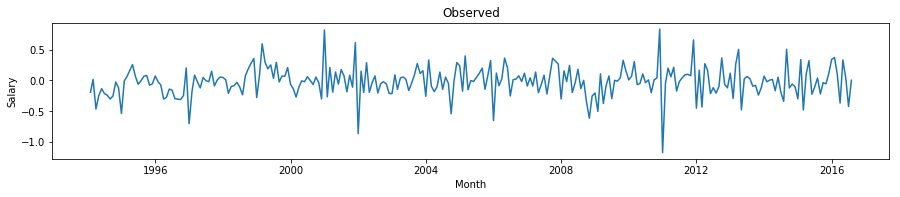

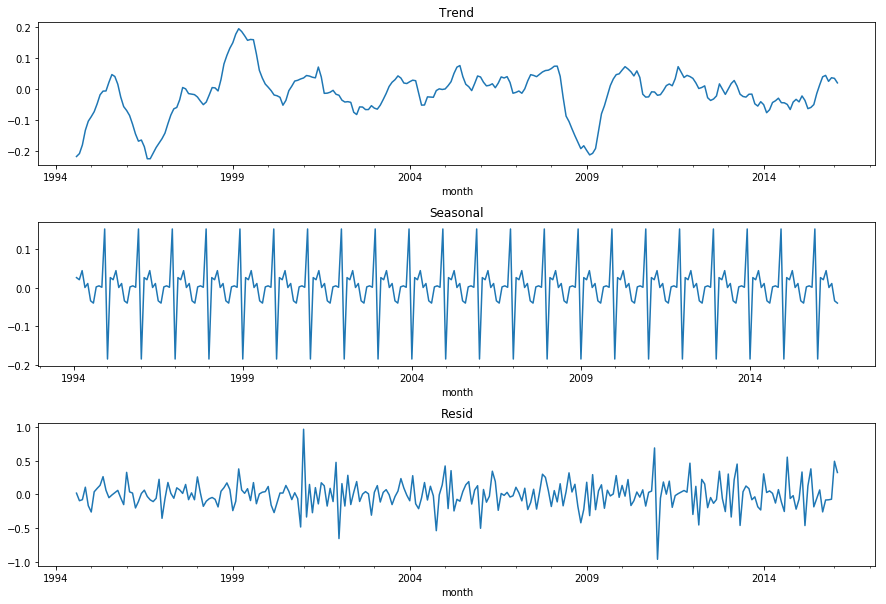

In [9]:
salary['BoxCox_Diff2'] = salary['BoxCox_SeasDiff'] - salary['BoxCox_SeasDiff'].shift(1)

decomposition(salary.BoxCox_Diff2.dropna())

print("Критерий Дики-Фуллера: p=", sm.tsa.stattools.adfuller(salary['BoxCox_Diff2'].dropna())[1])

print("\nTRANSFORMED WITH BOXCOX SEASONAL AND USUAL DIFF:")

Теперь однозначно сложно выделить какой-либо тренд у ряда. Если посмотреть на остатки, они распределены по обе стороны от нулевой оси более-менее равномерно и без какой-либо структуры. 
Критерий Дики-Фуллера теперь с достаточно уверенной точностью отвергает гипотезу о нестационарности ряда. 

Соответственно, в нашей моделе будем проводить сезонное диффернцирование с D = 1 и обычное с d = 1. 

## Выбор начальных приближений для p,q,P,Q

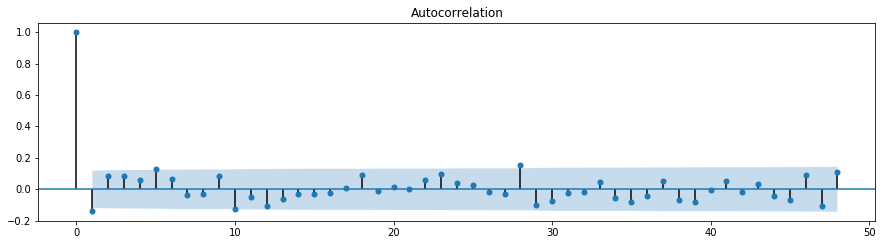

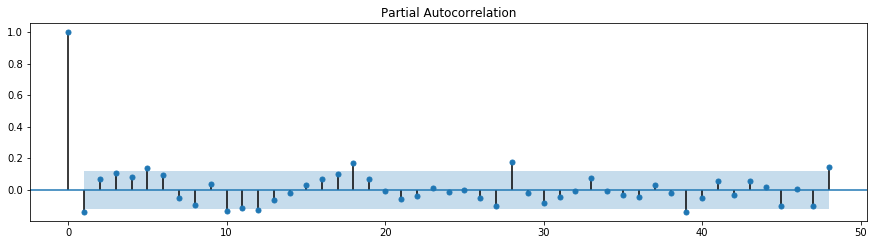

In [10]:
plt.figure(figsize = (15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary['BoxCox_Diff2'].dropna().values.squeeze(), lags=48, ax=ax)
plt.show()

plt.figure(figsize = (15,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary['BoxCox_Diff2'].dropna().values.squeeze(), lags=48, ax=ax)
plt.show()

Исходя из верхнего графика берем Q = 0, q = 10.
Исходя из нижнего графика берем P = 1, p = 11. 

Заметим, что мы не берем в расчет тот момент, что для P*S = 48 автокорреляция является значительной. Это слишком большое значение. Мы сможем к нему вернуться позднее, если не сможем побобрать достаточно хорошую модель. 

In [35]:
ps = range(0, 12)
d=1
qs = range(0, 11)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

In [36]:
%%time

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary['WAG_BoxCox'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #параметры, на которых модель не обучается пропускаем и переходим к следующему набору
    except ValueError:
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 10min 27s


In [37]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
87   (4, 6, 1, 0) -25.234526
99   (5, 5, 1, 0) -25.097134
85   (4, 5, 1, 0) -24.697967
115  (6, 5, 1, 0) -22.643037
89   (4, 7, 1, 0) -22.308733


Получили лучшую модель:

In [38]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         WAG_BoxCox   No. Observations:                  284
Model:             SARIMAX(4, 1, 6)x(1, 1, 0, 12)   Log Likelihood                  24.617
Date:                            Thu, 30 Aug 2018   AIC                            -25.235
Time:                                    16:37:55   BIC                             17.991
Sample:                                01-01-1993   HQIC                            -7.879
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6178      0.208      2.965      0.003       0.209       1.026
ar.L2         -0.4182      0.066   

Гипотеза гетероскедастичности остатков отвергается на уровне 0.05. Q-тест Льюнг - Бокса не отвергает нулевую гипотезу о случайности остатков.

Проведем анализ остатков

Критерий Стьюдента: 0.183749548219
Критерий Дики-Фуллера: 3.52268397274e-29


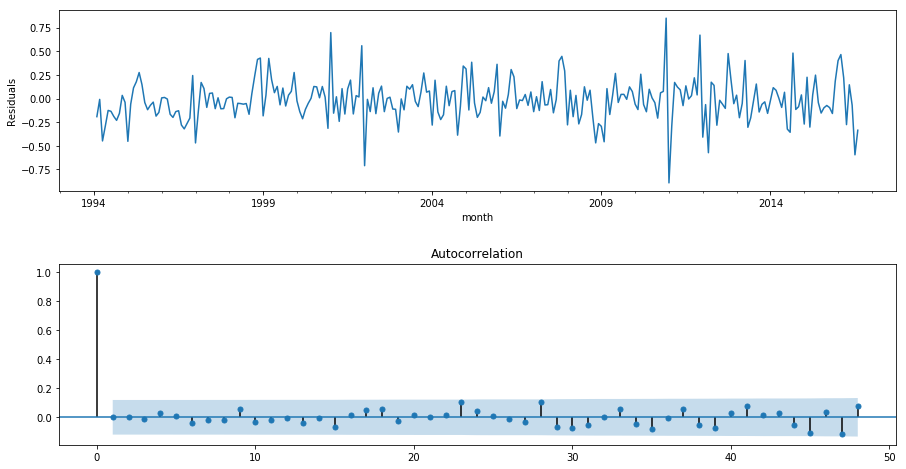

In [39]:
plt.figure(figsize = (15,8))
plt.subplots_adjust(hspace = 0.4)

plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print('Критерий Стьюдента:',stats.ttest_1samp(best_model.resid[13:],0)[1])
print('Критерий Дики-Фуллера:',sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

* Остатки модели стационарны. Подтверждено критерием Дики-Фуллера, а также визуально. 
* Остатки модели неавтокоррелированы Подтверждено критерием Льюнга-Бокса и коррелограммой. 
* Остатки модели несмещеные. Подверждено критерием Стьюдента и визуально.


Посмотрим, насколько хорошо модель описывает данные

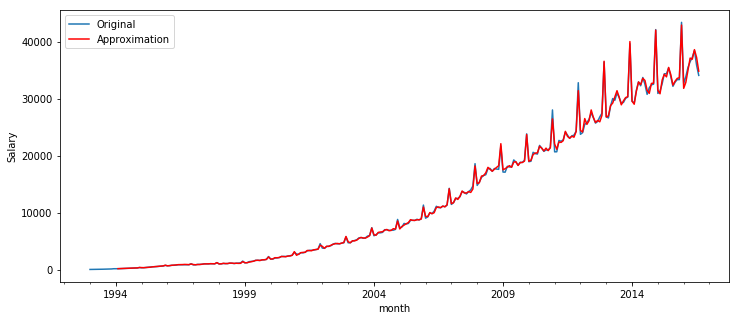

In [44]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize = (12,5))
salary.WAG_C_M.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Salary')
plt.legend(['Original', 'Approximation'])
plt.show()


Модель хорошо описывает данные. Можно построить предикт на 2 года вперед.

## Прогнозирование с помощью финальной модели

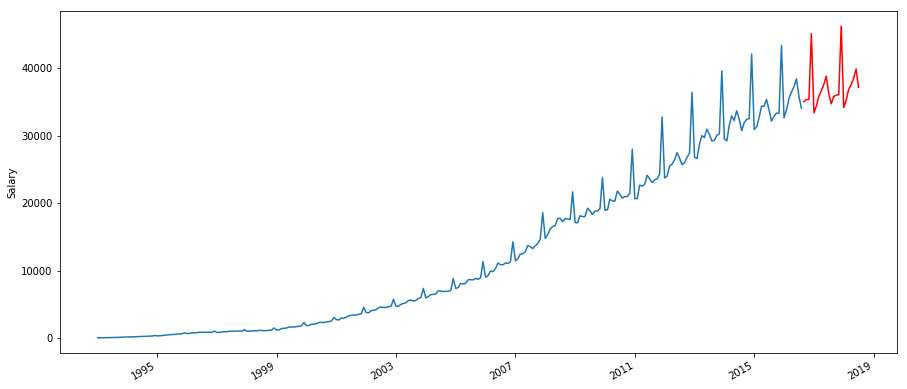

In [50]:
import datetime
from dateutil.relativedelta import relativedelta

salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=284, end=307), lmbda)

plt.figure(figsize = (15,7))
salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Salary')
plt.show()

Построенная модель хорошо прогнозирует данные. Включен и тренд и дисперссия. 